In [4]:
# import necessary libraries
import os
import shutil
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [65]:
# Define variables

# Raw dataset path
raw_dataset_path = "/home/gabridele/Desktop/psych_dataset"

# Preprocessed dataset path
preproc_dataset = "/home/gabridele/Desktop/preproc_psych"

# Participants file path
participants_file = "/home/gabridele/Desktop/psych_dataset/participants.tsv"

# Name and location of output excel file
output_excel_file = '/home/gabridele/Desktop/preproc_psych/fd_values_scap-fMRI.xlsx'

# Name and location of transposed excel file
transposed_excel_file = '/home/gabridele/Desktop/preproc_psych/fd_values_scap-fMRI_transposed.xlsx'


# Manage and adjust folders

1. Clean up: remove extra folders (derivatives, fmri) and move sub-* to main dir

In [ ]:
## move sub-* folders into main folder and delete unnecessary in-between folders
#also copies html files to the corresponding sub-* folder

# Define source directory containing sub-* folders
source_root = "/home/gabridele/Desktop/preproc_psych"

# Define target directory
target_root = "/home/gabridele/Desktop/preproc_psych"

# Function to move sub-* folders and sub-*.html files to the target directory
def move_sub_folders_and_html(source_dir, target_dir):
    # Get a list of sub-* folders already present in the target directory
    existing_sub_folders = [d for d in os.listdir(target_dir) if d.startswith("sub-")]
    
    for root, dirs, files in os.walk(source_dir):
        for sub_dir in dirs:
            if sub_dir.startswith("sub-"):
                if sub_dir in existing_sub_folders:
                    print(f"Skipping {sub_dir} as it already exists in the target directory.")
                    continue
                
                sub_folder_path = os.path.join(root, sub_dir)
                target_sub_folder_path = os.path.join(target_dir, sub_dir)
                shutil.move(sub_folder_path, target_sub_folder_path)
                print(f"Moved {sub_dir} to {target_sub_folder_path}")
    
    # Move HTML files to their corresponding sub-* folders
    for root, dirs, files in os.walk(source_dir):
        for file_name in files:
            if file_name.endswith(".html"):
                source_file_path = os.path.join(root, file_name)
                sub_folder_name_match = re.match(r"sub-(\d+).html", file_name)  # Use regex to extract sub-* folder name
                if sub_folder_name_match:
                    sub_folder_name = sub_folder_name_match.group(1)
                    target_sub_folder_path = os.path.join(target_dir, f"sub-{sub_folder_name}")
                    target_file_path = os.path.join(target_sub_folder_path, file_name)
                    
                    if not os.path.exists(target_sub_folder_path):
                        print(f"Corresponding sub-* folder 'sub-{sub_folder_name}' is missing for HTML file: {file_name}")
                        continue
                    
                    shutil.move(source_file_path, target_file_path)
                    print(f"Moved {file_name} to {target_file_path}")
                else:
                    print(f"Failed to extract sub-* folder name from HTML file: {file_name}")

# Call the function to move sub-* folders and HTML files
move_sub_folders_and_html(source_root, target_root)

# Remove the empty folders from which the sub-* folders were copied
for root, dirs, files in os.walk(source_root, topdown=False):
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        if not os.listdir(dir_path):
            os.rmdir(dir_path)
            print(f"Removed empty folder: {dir_path}")

2. Code to copy dwi and beh into preprocessed folders. so that dataset is complete. also prints a csv file with folders that are missing from preproc dataset, hence that have been removed during preprocessing by authors

In [ ]:
# Source and target directories
source_root = "/home/gabridele/Desktop/psych_dataset"
target_root = "/home/gabridele/Desktop/preproc_psych"

def copy_folders(source_dir, target_dir):
    missing_subfolders = {}  # Dictionary to store missing subfolders
    
    for sub_folder in os.listdir(source_dir):
        if sub_folder.startswith("sub-") and os.path.isdir(os.path.join(source_dir, sub_folder)):
            source_sub_dir = os.path.join(source_dir, sub_folder)
            target_sub_dir = os.path.join(target_root, sub_folder)  # Find target sub-* folder path
            
            # Check if the target sub-* folder exists
            if target_sub_dir is None:
                print(f"The corresponding sub-* folder '{sub_folder}' doesn't exist in the target directory '{target_root}'.")
                missing_subfolders[sub_folder] = source_sub_dir
                continue
            
            # Check if "dwi" and "beh" folders already exist in the target directory
            dwi_target_dir = os.path.join(target_sub_dir, "dwi")
            beh_target_dir = os.path.join(target_sub_dir, "beh")
            if os.path.exists(dwi_target_dir) and os.path.exists(beh_target_dir):
                print(f"'dwi' and 'beh' folders already exist in the target sub-* folder '{sub_folder}'. Skipping...")
                continue
            
            # Check if "dwi" folder exists
            dwi_folder = os.path.join(source_sub_dir, "dwi")
            if os.path.exists(dwi_folder) and os.path.isdir(dwi_folder):
                try:
                    shutil.copytree(dwi_folder, os.path.join(target_sub_dir, "dwi"))
                except FileExistsError:
                    print(f"'dwi' folder already exists in the target sub-* folder '{sub_folder}'. Skipping...")
            else:
                print(f"No 'dwi' folder found in {source_sub_dir}")
            
            # Check if "beh" folder exists
            beh_folder = os.path.join(source_sub_dir, "beh")
            if os.path.exists(beh_folder) and os.path.isdir(beh_folder):
                try:
                    shutil.copytree(beh_folder, os.path.join(target_sub_dir, "beh"))
                except FileExistsError:
                    print(f"'beh' folder already exists in the target sub-* folder '{sub_folder}'. Skipping...")
            else:
                print(f"No 'beh' folder found in {source_sub_dir}")
    
    # Save missing subfolders dictionary to CSV file
    save_missing_subfolders_csv(missing_subfolders)

# Function to save missing subfolders dictionary to CSV file
def save_missing_subfolders_csv(missing_subfolders):
    if missing_subfolders:
        with open("missing_subfolders.csv", "w", newline="") as csvfile:
            fieldnames = ["Subfolder", "Source Directory"]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for subfolder, source_dir in missing_subfolders.items():
                writer.writerow({"Subfolder": subfolder, "Source Directory": source_dir})
        print("Missing subfolders saved to 'missing_subfolders.csv'")
    else:
        print("No missing subfolders found.")

# Copy "dwi" and "beh" folders from source to target directory
copy_folders(source_root, target_root)


3. Check for missing folders and task files within func

In [5]:
def check_missing_files(preproc_psych_path):
    missing_files_info = []
    for root, dirs, files in os.walk(preproc_psych_path):
        for sub_dir in dirs:
            if sub_dir.startswith("sub-"):
                sub_folder_path = os.path.join(root, sub_dir)
                required_folders = ["anat", "func", "dwi"]
                missing_folders = [folder for folder in required_folders if not os.path.exists(os.path.join(sub_folder_path, folder))]
                func_path = os.path.join(sub_folder_path, "func")
                missing_func_files = []
                if os.path.exists(func_path):
                    func_files = os.listdir(func_path)
                    if not any("scap" in file_name for file_name in func_files):
                        missing_func_files.append("scap")
                if missing_folders or missing_func_files:
                    missing_files_info.append({"Subject": sub_dir, "Missing Folders": ", ".join(missing_folders), "Missing Func Files": ", ".join(missing_func_files)})
    return missing_files_info

def csv_missing_files(missing_files_info, csv_file_name):
    if missing_files_info:
        with open(csv_file_name, "w", newline="") as csvfile:
            fieldnames = ["Subject", "Missing Folders", "Missing Func Files"]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(missing_files_info)
        print(f"Missing files information saved to '{csv_file_name}'")
    else:
        print("No missing folders found.")

# Define the path to the preproc_psych folder
preproc_psych_path = "/home/gabridele/Desktop/preproc_psych"

# Check for missing files information
missing_files_info = check_missing_files(preproc_psych_path)

# Save information about missing files to a CSV file
csv_file_name = "missing_files_info.csv"
csv_missing_files(missing_files_info, csv_file_name)

Missing files information saved to 'missing_files_info.csv'


# Extract and handle FD values

4. Create an xlxs file containing, per subj and task, the subject's info and the FD values. Along with the mean, percentage of FD beyond 0.2 and 0.5 and their absolute values

In [ ]:
def extract_additional_info(participants_file):

    # Read participants.tsv file
    participants_df = pd.read_csv(participants_file, sep='\t')

    participants_df['diagnosis'] = participants_df['diagnosis'].replace('SCHZ', 'SCZ')
    
    # Extract required columns
    additional_info_df = participants_df[['participant_id', 'diagnosis', 'age', 'gender']]

    return additional_info_df

def extract_fd_values(preproc_dataset, participants_file, output_excel_file):
    # Extract additional information
    additional_info_df = extract_additional_info(participants_file)

    # Create an empty DataFrame to store FD values and statistics
    fd_data = pd.DataFrame()

    # Iterate through sub-folders in the main folder
    for root, dirs, files in os.walk(preproc_dataset):
        for sub_dir in dirs:
            if sub_dir.startswith("sub-"):
                func_folder = os.path.join(root, sub_dir, "func")
                if os.path.isdir(func_folder):
                    # Find the confounds file within the func folder
                    confounds_files = [file for file in os.listdir(func_folder) if f"-scap_bold_confounds.tsv" in file]
                    if confounds_files:
                        confounds_file = os.path.join(func_folder, confounds_files[0])
                        # Read the confounds file
                        confounds_data = pd.read_csv(confounds_file, delimiter="\t")
                        # Extract the FramewiseDisplacement column
                        fd_values = confounds_data["FramewiseDisplacement"]
                        # Add FD values to the DataFrame with subject ID as column name
                        subject_id = sub_dir  # Extract subject ID from folder name
                        fd_data[subject_id] = fd_values


    # Calculate statistics for FD values
    statistics_df = fd_data.describe()

    # Calculate percentage of values beyond thresholds and absolute count
    beyond_02_percentage = (fd_data > 0.2).sum() / fd_data.count() * 100
    beyond_05_percentage = (fd_data > 0.5).sum() / fd_data.count() * 100
    beyond_02_absolute = (fd_data > 0.2).sum()
    beyond_05_absolute = (fd_data > 0.5).sum()

    # Add statistics to the DataFrame
    statistics_df.loc["% > 0.2"] = beyond_02_percentage
    statistics_df.loc["% > 0.5"] = beyond_05_percentage
    statistics_df.loc["Absolute > 0.2"] = beyond_02_absolute
    statistics_df.loc["Absolute > 0.5"] = beyond_05_absolute

    # Merge additional information with statistical measures
    merged_df = pd.concat([additional_info_df.set_index('participant_id'), statistics_df.T], axis=1)

    # Save the DataFrame to an Excel file
    output_excel_path = os.path.join(preproc_dataset, output_excel_file)
    #exclude subjs without functional data
    merged_df = merged_df[merged_df['count'].notna()]
    merged_df.to_excel(output_excel_path)
    print(f"Data saved to {output_excel_path}")

extract_fd_values(preproc_dataset, participants_file, output_excel_file)

5. Transpose excel file to have subjects along the columns and values along the rows

In [86]:
# Read the Excel file into a DataFrame
df = pd.read_excel(output_excel_file, sheet_name="Sheet1", index_col=0)
print(df['diagnosis'].value_counts())
# Transpose the DataFrame
df_transposed = df.T

# Save the transposed DataFrame to a new Excel file
df_transposed.to_excel(transposed_excel_file, sheet_name="Sheet1")


diagnosis
CONTROL    122
SCZ         50
BIPOLAR     49
ADHD        40
Name: count, dtype: int64


6. Plot age distribution

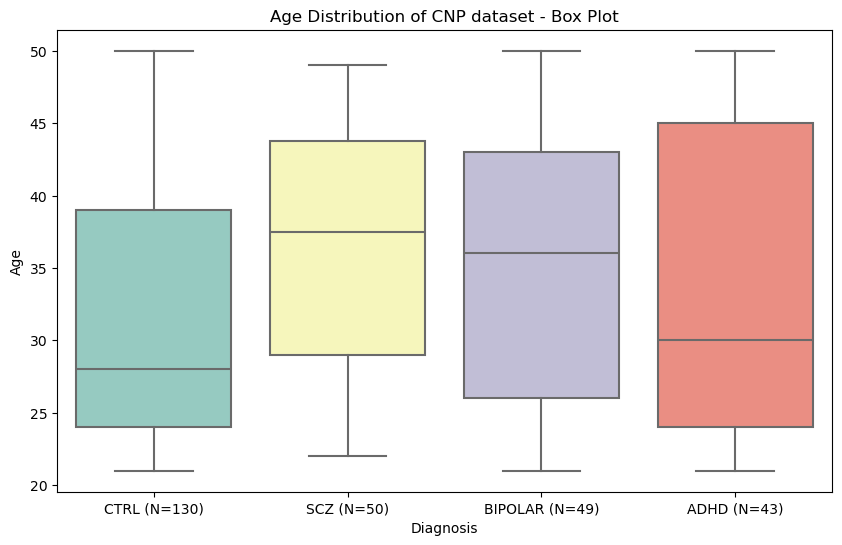

In [12]:
import pandas as pd 
data = pd.read_csv(participants_file, sep='\t')

# create plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='diagnosis', y='age', data=data, palette="Set3")
plt.xlabel('Diagnosis')
custom_labels = ["CTRL (N=130)", "SCZ (N=50)", "BIPOLAR (N=49)", "ADHD (N=43)"]
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)
plt.ylabel('Age')
plt.title('Age Distribution of CNP dataset - Box Plot')
plt.show()


8. Plot FD values with boxplot. Each boxplot represents a diagnosis

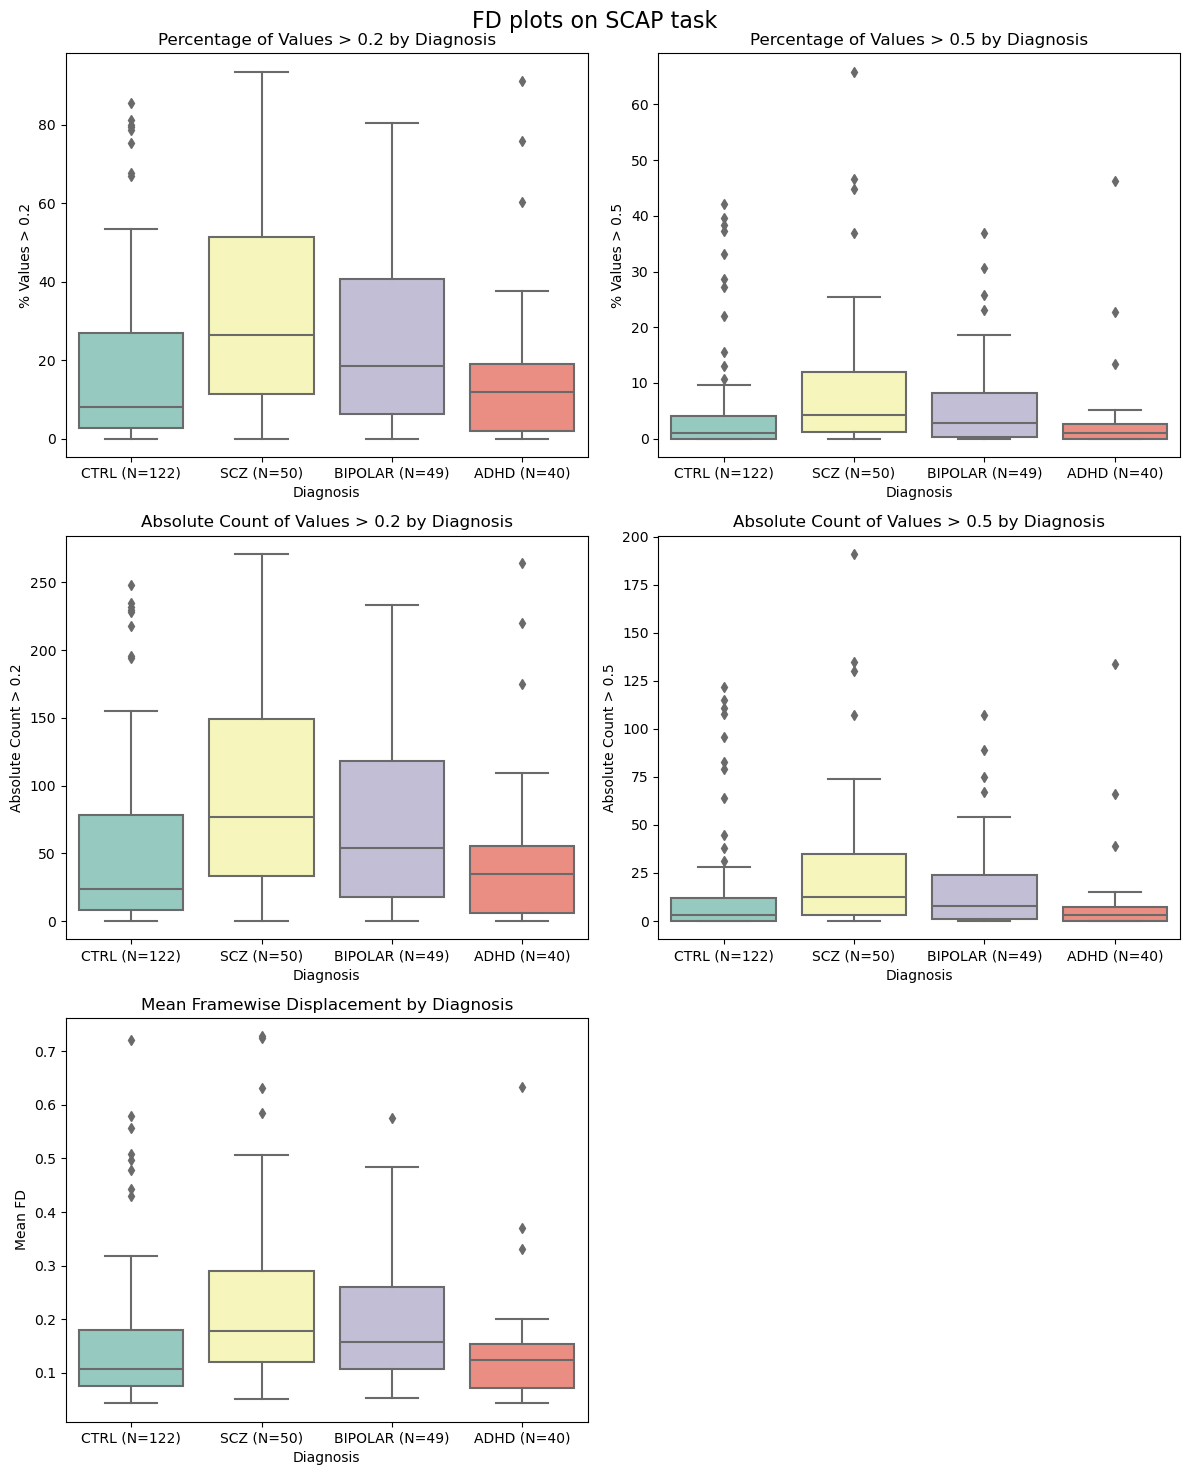

In [87]:
# Read the transposed Excel file into a DataFrame
df = pd.read_excel(output_excel_file, sheet_name="Sheet1")

custom_labels = ["CTRL (N=122)", "SCZ (N=50)", "BIPOLAR (N=49)", "ADHD (N=40)"]

# Create a subplot layout with 3 rows and 2 columns
plt.figure(figsize=(12, 15))

# Boxplot for percentage of values > 0.2 by diagnosis
plt.subplot(3, 2, 1)
sns.boxplot(x="diagnosis", y="% > 0.2", data=df, palette="Set3")
plt.title("Percentage of Values > 0.2 by Diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("% Values > 0.2")
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)

# Boxplot for percentage of values > 0.5 by diagnosis
plt.subplot(3, 2, 2)
sns.boxplot(x="diagnosis", y="% > 0.5", data=df, palette="Set3")
plt.title("Percentage of Values > 0.5 by Diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("% Values > 0.5")
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)

# Boxplot for absolute count of values > 0.2 by diagnosis
plt.subplot(3, 2, 3)
sns.boxplot(x="diagnosis", y="Absolute > 0.2", data=df, palette="Set3")
plt.title("Absolute Count of Values > 0.2 by Diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("Absolute Count > 0.2")
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)

# Boxplot for absolute count of values > 0.5 by diagnosis
plt.subplot(3, 2, 4)
sns.boxplot(x="diagnosis", y="Absolute > 0.5", data=df, palette="Set3")
plt.title("Absolute Count of Values > 0.5 by Diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("Absolute Count > 0.5")
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)

# Boxplot for mean FD values by diagnosis
plt.subplot(3, 2, 5)
sns.boxplot(x="diagnosis", y="mean", data=df, palette="Set3")
plt.title("Mean Framewise Displacement by Diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("Mean FD")
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)

plt.suptitle("FD plots on SCAP task", fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

9. Count number of subjects per diagnosis

In [100]:
# Read the Excel file
df = pd.read_excel(output_excel_file, sheet_name="Sheet1")

# Filter the DataFrame to include only rows with non-null values in the 'mean' column
df_filtered = df.dropna(subset=['mean'])

# Count the number of subjects grouped by diagnosis
subject_count_by_diagnosis = df_filtered.groupby('diagnosis').size()

# Print the count
print("Number of subjects grouped by diagnosis:")
print(subject_count_by_diagnosis)

Number of subjects grouped by diagnosis:
diagnosis
ADHD        40
BIPOLAR     49
CONTROL    122
SCZ         50
dtype: int64


10. Visually check for type of distribution with histograms

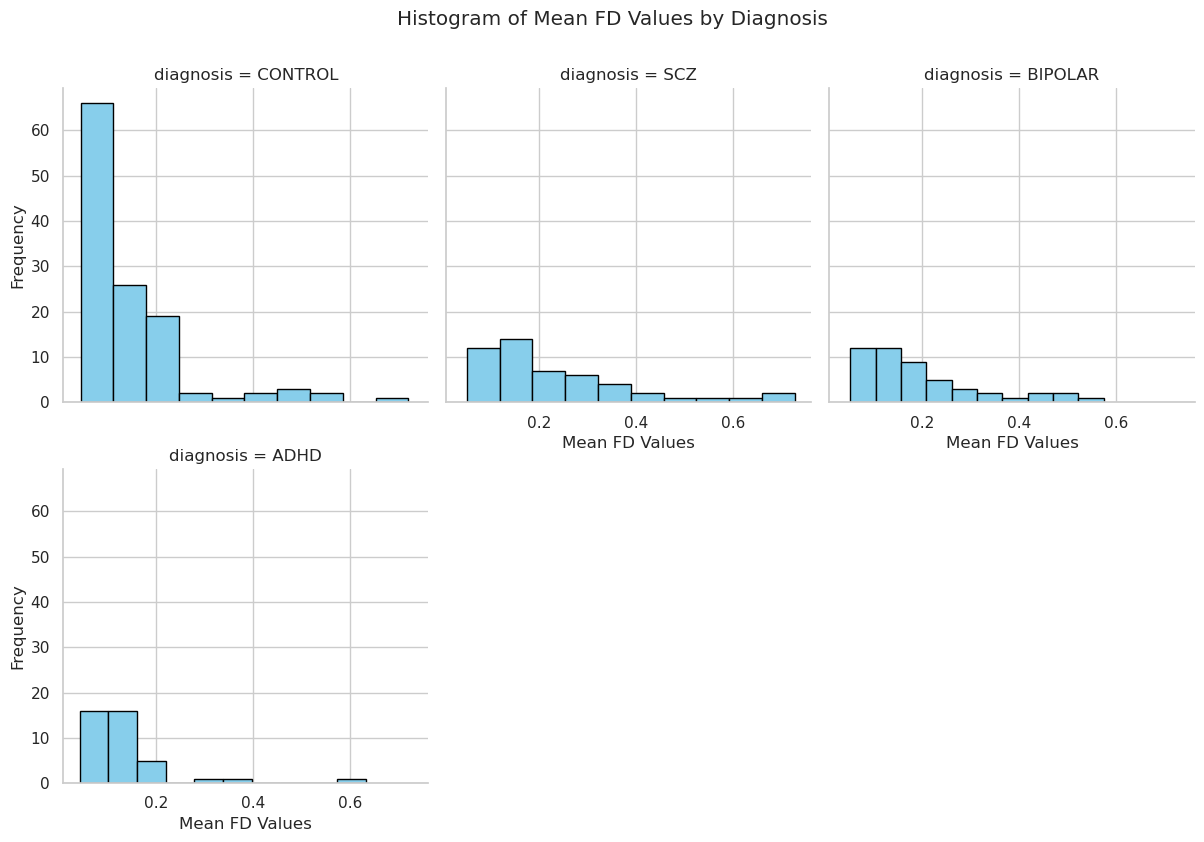

In [101]:
# Create a FacetGrid with col_wrap=3
g = sns.FacetGrid(df, col="diagnosis", col_wrap=3, height=4)

# Map histograms for the "mean" column
g.map(plt.hist, "mean", bins=10, color='skyblue', edgecolor='black')

# Add labels and title
g.set_axis_labels("Mean FD Values", "Frequency")
g.figure.suptitle("Histogram of Mean FD Values by Diagnosis", y=1.05)

# Show the plot
plt.show()

11. Use statistical test to check if distribution is normal

In [102]:
df = pd.read_excel(output_excel_file, sheet_name="Sheet1")

# Group the data by the "diagnosis" column
grouped = df.groupby("diagnosis")

# Perform the normality test for each group
for name, group in grouped:
    print(f"Diagnosis: {name}")
    mean_data = group["mean"]
    statistic, p_value = stats.normaltest(mean_data, nan_policy='omit')
    print(f"Normality Test Statistic: {statistic}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print("The sample does not appear to come from a normal distribution (reject H0)")
    else:
        print("The sample appears to come from a normal distribution (fail to reject H0)")
    print()

Diagnosis: ADHD
Normality Test Statistic: 51.662177944920415
P-value: 6.049236970245749e-12
The sample does not appear to come from a normal distribution (reject H0)

Diagnosis: BIPOLAR
Normality Test Statistic: 13.546406394266427
P-value: 0.00114402424034848
The sample does not appear to come from a normal distribution (reject H0)

Diagnosis: CONTROL
Normality Test Statistic: 83.29714287071052
P-value: 8.17062439698848e-19
The sample does not appear to come from a normal distribution (reject H0)

Diagnosis: SCZ
Normality Test Statistic: 19.410361529351373
P-value: 6.09668207027951e-05
The sample does not appear to come from a normal distribution (reject H0)



12. Mann-Whitney U test, a non-parametric test to assess statistical significance. With two types of effect sizes

In [103]:
# Create a list of unique diagnoses
unique_diagnoses = df['diagnosis'].unique()

# Perform Mann-Whitney U test for all pairs of unique diagnoses
for i in range(len(unique_diagnoses)):
    for j in range(i+1, len(unique_diagnoses)):
        diagnosis1 = unique_diagnoses[i]
        diagnosis2 = unique_diagnoses[j]
        
        # Select data for the two diagnoses
        data1 = df[df['diagnosis'] == diagnosis1]['mean']
        data2 = df[df['diagnosis'] == diagnosis2]['mean']
        
        # Perform Mann-Whitney U test
        stat, p_value = stats.mannwhitneyu(data1, data2, nan_policy='omit')
        
        n1 = len(data1)
        n2 = len(data2)
        
        # Calculate standardized test statistic (z)
        z = (stat - (n1 * n2 / 2)) / np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
        
        # Calculate Effect Size (r)
        r = np.abs(z) / np.sqrt(n1 + n2)

        # Convert data1 and data2 to NumPy arrays
        #data1 = np.array(data1)
        #data2 = np.array(data2)

        # Reshape data1 and data2 to have a second dimension
        #data1_reshaped = data1[:, np.newaxis]
        #data2_reshaped = data2[:, np.newaxis]

        # Calculate R
        #R = np.sum(data1_reshaped > data2) + 0.5 * np.sum(data1_reshaped == data2)

        # Calculate CLES
        #cles = (n1 * n2 + R) / (n1 * n2 * 2)
        
        # Print results
        print(f"Mann-Whitney U Test between {diagnosis1} and {diagnosis2}:")
        print(f"U Statistic: {stat}")
        print(f"P-value: {p_value}")
        if p_value < 0.05:
            print("The difference is statistically significant.")
        else:
            print("The difference is not statistically significant.")
        print(f"Effect size between {diagnosis1} and {diagnosis2}: {r}")
        #print(f"Common Language Effect Size (CLES) between {diagnosis1} and {diagnosis2}: {cles}\n")
        print()

Mann-Whitney U Test between CONTROL and SCZ:
U Statistic: 1796.0
P-value: 2.3688149063313397e-05
The difference is statistically significant.
Effect size between CONTROL and SCZ: 0.3461169047357743
Common Language Effect Size (CLES) between CONTROL and SCZ: 0.6381538461538462


Mann-Whitney U Test between CONTROL and BIPOLAR:
U Statistic: 2160.0
P-value: 0.0046496337762354425
The difference is statistically significant.
Effect size between CONTROL and BIPOLAR: 0.24784605136790616
Common Language Effect Size (CLES) between CONTROL and BIPOLAR: 0.6695447409733124


Mann-Whitney U Test between CONTROL and ADHD:
U Statistic: 2545.0
P-value: 0.6848269635971678
The difference is not statistically significant.
Effect size between CONTROL and ADHD: 0.06676164852596962
Common Language Effect Size (CLES) between CONTROL and ADHD: 0.7276386404293381


Mann-Whitney U Test between SCZ and BIPOLAR:
U Statistic: 1414.0
P-value: 0.18709383925777834
The difference is not statistically significant.
Effe